# Single-stage optimization prototype
This is the prototype for single-stage optimization using QUADCOIL.
Note that the winding surface's poloidal parameterization is not yet 
robust. 

In [26]:
import jax
jax.devices()
from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", False)

In [27]:
jnp.linspace(1,10,10).dtype

dtype('float32')

In [30]:
# This script generates the plasma surface, winding surface and initial filaments for the 
# force minimization study. Uses the regcoil branch and quadcoil_proto.

import os
# os.environ['XLA_FLAGS'] = '--xla_dump_to=./jax_dump'
# os.environ['JAX_PLATFORMS'] = 'cpu'
import sys
import matplotlib.pyplot as plt
from simsopt.geo import SurfaceRZFourier, plot
from simsopt.field import CurrentPotentialSolve, CurrentPotentialFourier
from simsopt import save, load
from functools import partial
from jax import jit, vmap, jacfwd
from jax.lax import while_loop
import optax
import optax.tree_utils as otu
import time


# Loading QUADCOIL
quadcoil_path = '..'
sys.path.insert(1, quadcoil_path)
# The directory of the c++ code imported in self_force_operator
# must be included separately
sys.path.insert(1, quadcoil_path + '/build')
sys.path.insert(1, quadcoil_path + '/objectives')

from winding_surface_jax import (
    gen_winding_surface_atan,
    gen_winding_surface_atan_legacy,
    dof_to_gamma, 
    winding_surface_field_Bn, 
    cp_make_mn, 
    winding_surface_field_Bn_GI
)
from jax_solver import solve_quad_unconstrained, eval_quad_scaled, solve_quad_constrained, run_opt
from plotting_utils import plot_coil_Phi_IG
from grid_curvature_operator_jax import grid_curvature_cylindrical
from f_b_and_k_operators_jax import \
    f_B_and_current_scale, \
    K2, K_theta, K_helper
from utils import avg_order_of_magnitude


# Loading plasma surface and setting up parameters (replace with your own equilibrium and parameters)

In [33]:
''' --- Loading configs --- '''


# Obtaining a list of all configs
path_plasma_surface = 'plasma_surface/'
list_plasma_surface = os.listdir(path_plasma_surface)
path_vcasing = '2023-09-14.MagneticGradientScalength/vcasing/'
list_vcasing= os.listdir(path_vcasing)
path_bnorm = '2023-09-14.MagneticGradientScalength/bnorm/'
list_bnorm = os.listdir(path_bnorm)
''

''

In [34]:
# Finding a case with name containing the substring. 
# You can change current_name to something you like.
substring='li383'
print('Finding equilibrium containing:', substring)
for i_config, item in enumerate(list_plasma_surface):
    if substring in item:
        break

print(i_config)

current_plasma_surface = list_plasma_surface[i_config]
current_name = current_plasma_surface[:-4]
print('Name:', current_name)



Finding equilibrium containing: li383
31
Name: li383_1.4m_aScaling


In [37]:
''' --- Settings --- '''
n_phi_plasma = 32
n_theta_plasma = 32
# n_phi is per field period
n_phi_winding = 33
n_theta_winding = 33
# In this test file, winding and eval 
# grids must be the same because that's
# how it is in the mosek version. Otherwise
# the comparison will not be valid.
n_phi_eval = n_phi_winding
n_theta_eval = n_theta_winding

# The first constraint is a peak current density constraint that mimics the 
# coil-coil distance constraint in filament optimization. 
# Here we prescribe some arbitrary coil number by multiplying this 
# number to the aspect ratio. The more coils there are, the more accurate the 
# proxy should be
coil_per_aspect_ratio = 4.6503866245115155
mpol_cp = 4
ntor_cp = 4


mpol_winding = 7 # 10
ntor_winding = 7 # 10


In [51]:
from numpy import loadtxt
''' --- Loading plasma surface --- '''

# Loads the plasma surface into plasma_surface. Replace with your own surface.
surf_dict = jnp.load(path_plasma_surface + current_plasma_surface, allow_pickle=True).item()
plasma_dofs = surf_dict['dofs'].astype(jnp.float32)
stellsym = surf_dict['stellsym']
nfp = surf_dict['nfp']
quadpoints_phi_plasma = jnp.linspace(0, 1/nfp, n_phi_plasma, endpoint=False)
quadpoints_theta_plasma = jnp.linspace(0, 1, n_theta_plasma, endpoint=False)
plasma_surface = SurfaceRZFourier(
    nfp=nfp, 
    stellsym=stellsym, 
    mpol=surf_dict['mpol'], 
    ntor=surf_dict['ntor'], 
    quadpoints_phi=quadpoints_phi_plasma, 
    quadpoints_theta=quadpoints_theta_plasma, 
)
plasma_surface.set_dofs(plasma_dofs)


''' --- Setting current --- '''


net_poloidal_current_amperes = surf_dict['net_poloidal_current'].astype(jnp.float32)
net_toroidal_current_amperes = 0


''' --- Loading B_plasma --- '''


# Loads the normal magnetic field at the plasma surface
current_vcasing = 'vcasing_' + current_name + '.nc'
current_bnorm = 'bnorm.' + current_name
if current_bnorm in list_bnorm:
    print(current_bnorm, 'found. Loading virtual casing.')
    bnorm_data = loadtxt(path_bnorm+current_bnorm)
    bnorm_m = jnp.array(bnorm_data[:, 0], dtype=int)
    bnorm_n = jnp.array(bnorm_data[:, 1], dtype=int)
    bnorm_values = bnorm_data[:, 2]
    eval_grid_phi, eval_grid_theta = jnp.meshgrid(
        plasma_surface.quadpoints_phi, 
        plasma_surface.quadpoints_theta,
        indexing='ij'
    )
    Bnormal_plasma = jnp.sum(bnorm_values[:, None, None] * jnp.sin(
        bnorm_m[:, None, None] * eval_grid_phi[None, :, :] * jnp.pi * 2
        + bnorm_n[:, None, None] * eval_grid_theta[None, :, :] * jnp.pi * 2
    ), axis=0)
else:
    if current_vcasing in list_vcasing:
        raise TypeError('Equilibrium has no B_norm, but is not a vacuum field! '\
            'This requires virtual_casing to run, which is not functioning '\
            'properly.')
    Bnormal_plasma = jnp.zeros((
        len(plasma_surface.quadpoints_phi),
        len(plasma_surface.quadpoints_theta)
    ))

Bnormal_plasma_flat = Bnormal_plasma.flatten()



bnorm.li383_1.4m_aScaling found. Loading virtual casing.


In [52]:
plasma_dofs.dtype

dtype('float32')

In [58]:
''' --- Calculating aspect ratio --- '''
plasma_aspect = plasma_surface.aspect_ratio()
total_coil_num_temp = coil_per_aspect_ratio * plasma_aspect
coils_per_half_field_period = round(total_coil_num_temp/2/plasma_surface.nfp)
total_coil_num = coils_per_half_field_period*2*plasma_surface.nfp



''' --- Calculating constraint values --- '''
# Set your min coil coil distance constraint here
coil_coil_distance = (0.5 * plasma_surface.minor_radius()).astype(jnp.float32)
kappa_threshold = (1/(0.2 * plasma_surface.minor_radius())).astype(jnp.float32)
coil_plasma_distance = (plasma_surface.minor_radius() * 2).astype(jnp.float32)



In [67]:
''' Settings '''
current_per_coil = net_poloidal_current_amperes/total_coil_num
max_K2 = (current_per_coil/coil_coil_distance)**2
max_KK = max_K2 * kappa_threshold

# The actual proxy for that plasma surface
Given coil-coil, coil-plasma spacing and maximum curvature requirements

In [68]:
quadpoints_phi_winding = jnp.linspace(0, 1, n_phi_winding*nfp, endpoint=False)
quadpoints_theta_winding = jnp.linspace(0, 1, n_theta_winding, endpoint=False)
quadpoints_phi_eval = jnp.linspace(0, 1/nfp, n_phi_eval, endpoint=False)
quadpoints_theta_eval = jnp.linspace(0, 1, n_theta_eval, endpoint=False)
mpol_plasma = plasma_surface.mpol
ntor_plasma = plasma_surface.ntor

In [82]:
# This is necessary to calculate gammadashes.

# @partial(jit, static_argnames=[
#     'nfp', 
#     'stellsym', 
#     'mpol_plasma',
#     'ntor_plasma',
#     'mpol_winding',
#     'ntor_winding',
# ])
def plasma_dofs_to_winding_dofs(
    # Dofs
    plasma_dofs,
    # Equilibrium and related parameters
    # Coil parameters
    coil_plasma_distance,
    # Numerical parameters
    nfp, 
    stellsym, 
    mpol_plasma,
    ntor_plasma,
    quadpoints_phi_plasma,
    quadpoints_theta_plasma,
    mpol_winding=10, 
    ntor_winding=10,
):

    theta_mesh_plasma, phi_mesh_plasma = jnp.meshgrid(quadpoints_theta_plasma, quadpoints_phi_plasma)

    ''' Plasma surface calculations'''
    # Quadrature points
    print('theta_mesh_plasma, phi_mesh_plasma', theta_mesh_plasma.dtype, phi_mesh_plasma.dtype)
    gamma_plasma = dof_to_gamma(
        dofs=plasma_dofs,
        phi_grid=phi_mesh_plasma, 
        theta_grid=theta_mesh_plasma, 
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_plasma, ntor=ntor_plasma)
    ''' Generating winding surface '''

    winding_dofs = gen_winding_surface_atan(
        gamma_plasma=gamma_plasma, 
        d_expand=coil_plasma_distance, 
        nfp=nfp, stellsym=stellsym,
        unitnormal=None,
        mpol=mpol_winding, ntor=ntor_winding,
        tol_expand=0.9,
        lam_tikhnov=0.9,
    )
    return(winding_dofs, gamma_plasma)

In [73]:

@partial(jit, static_argnames=[
    'nfp', 
    'stellsym', 
    'mpol_plasma',
    'ntor_plasma',
    'mpol_winding',
    'ntor_winding',
    'mpol_cp', 
    'ntor_cp', 
    'init_mode',
    'tol_outer',
    'tol_inner',
    'max_iter_inner',
    'max_iter_outer',
    'n_phi_eval_default',
    'n_theta_eval_default',
])
def quadcoil_curvature_study(
    # Dofs
    plasma_dofs,

    # Equilibrium and related parameters
    Bnormal_plasma,
    net_poloidal_current_amperes, # G
    net_toroidal_current_amperes, # I

    # Coil parameters
    coil_plasma_distance,
    max_K2,
    max_KK,

    # Numerical parameters
    nfp, 
    stellsym, 
    mpol_plasma,
    ntor_plasma,
    quadpoints_phi_plasma,
    quadpoints_theta_plasma,
    mpol_winding=10,
    ntor_winding=10,
    quadpoints_phi_winding=None,
    quadpoints_theta_winding=None,
    mpol_cp=4, 
    ntor_cp=4, 
    quadpoints_phi_eval=None,
    quadpoints_theta_eval=None,
    init_mode='zero',
    tol_outer=1e-3, # was 1e-5
    tol_inner=1e-3,
    max_iter_inner=1500,
    max_iter_outer=25,
    n_phi_eval_default=32,
    n_theta_eval_default=32,
):
    # Default quadrature point number
    if quadpoints_phi_winding is None:
        quadpoints_phi_winding = jnp.linspace(0, 1, n_phi_eval_default*nfp, endpoint=False)
        quadpoints_theta_winding = jnp.linspace(0, 1, n_theta_eval_default, endpoint=False)
    if quadpoints_phi_eval is None:
        quadpoints_phi_eval = jnp.linspace(0, 1/nfp, n_phi_eval_default, endpoint=False)
        quadpoints_theta_eval = jnp.linspace(0, 1, n_theta_eval_default, endpoint=False)
    
    
    ndof_cp = 2 * mpol_cp * ntor_cp + mpol_cp + ntor_cp
    if not stellsym:
        ndof_cp *= 2
    # Angle coordinates in a mesh
    theta_mesh_winding, phi_mesh_winding = jnp.meshgrid(quadpoints_theta_winding, quadpoints_phi_winding)
    theta_mesh_plasma, phi_mesh_plasma = jnp.meshgrid(quadpoints_theta_plasma, quadpoints_phi_plasma)
    theta_mesh_eval, phi_mesh_eval = jnp.meshgrid(quadpoints_theta_eval, quadpoints_phi_eval)

    # Flattening constant normal field
    Bnormal_plasma_flat = Bnormal_plasma.flatten()


    ''' Plasma surface calculations'''
    gammadash1_plasma = dof_to_gamma(
        dofs=plasma_dofs,
        phi_grid=phi_mesh_plasma, 
        theta_grid=theta_mesh_plasma, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=1,
        mpol=mpol_plasma, ntor=ntor_plasma)

    gammadash2_plasma = dof_to_gamma(
        dofs=plasma_dofs,
        phi_grid=phi_mesh_plasma, 
        theta_grid=theta_mesh_plasma, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash2_order=1,
        mpol=mpol_plasma, ntor=ntor_plasma)
    normal_plasma = jnp.cross(gammadash1_plasma, gammadash2_plasma, axis=-1)


    ''' Generating winding surface '''
    winding_dofs, gamma_plasma = plasma_dofs_to_winding_dofs(
        # Dofs
        plasma_dofs=plasma_dofs,
        # Equilibrium and related parameters
        # Coil parameters
        coil_plasma_distance=coil_plasma_distance,
        # Numerical parameters
        nfp=nfp, 
        stellsym=stellsym, 
        mpol_plasma=mpol_plasma,
        ntor_plasma=ntor_plasma,
        quadpoints_phi_plasma=quadpoints_phi_plasma,
        quadpoints_theta_plasma=quadpoints_theta_plasma,
        mpol_winding=mpol_winding, 
        ntor_winding=ntor_winding,
    )


    ''' Winding surface calculations '''
    # Winding operators
    # Operators
    gamma_winding = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_winding, 
        theta_grid=theta_mesh_winding, 
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash1_winding = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_winding, 
        theta_grid=theta_mesh_winding, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash2_winding = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_winding, 
        theta_grid=theta_mesh_winding, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash2_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gamma_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash1_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash2_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash2_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash1dash1_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=2,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash1dash2_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=1, dash2_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash2dash2_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash2_order=2,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    # Evaluation quadrature points
    normal_eval = jnp.cross(gammadash1_eval, gammadash2_eval, axis=-1)
    # Winding quadrature points (for calculating f_B)
    normal_winding = jnp.cross(gammadash1_winding, gammadash2_winding, axis=-1)


    ''' Calculating the NESCOIL (field error) operator '''
    m_cp, n_cp = cp_make_mn(mpol_cp, ntor_cp, stellsym)

    if stellsym:
        ndofs_half = ndof_cp
    else:
        ndofs_half = ndof_cp // 2
    dzeta_plasma = (quadpoints_phi_plasma[1] - quadpoints_phi_plasma[0])
    dtheta_plasma = (quadpoints_theta_plasma[1] - quadpoints_theta_plasma[0])
    dzeta_coil = (quadpoints_phi_winding[1] - quadpoints_phi_winding[0])
    dtheta_coil = (quadpoints_theta_winding[1] - quadpoints_theta_winding[0])

    normal_plasma_flat = normal_plasma.reshape(-1, 3)
    normal_winding_flat = normal_winding.reshape(-1, 3)
    points_plasma_flat = gamma_plasma.reshape(-1, 3)
    points_coil_flat = gamma_winding.reshape(-1, 3)
    gammadash1_winding_flat = gammadash1_winding.reshape(-1, 3)
    gammadash2_winding_flat = gammadash2_winding.reshape(-1, 3)

    gj_unscaled, _ = winding_surface_field_Bn(
        points_plasma_flat, # contig(points_plasma), 
        points_coil_flat, # contig(points_coil), 
        normal_plasma_flat, # contig(normal_plasma), 
        normal_winding_flat, # contig(normal), 
        stellsym, # self.winding_surface.stellsym, 
        jnp.ravel(phi_mesh_winding), # contig(zeta_coil), 
        jnp.ravel(theta_mesh_winding), # contig(theta_coil), 
        ndof_cp, # dummy, but used to keep the function signature the same
        m_cp[:ndofs_half], # contig(self.current_potential.m[:ndofs_half]), 
        n_cp[:ndofs_half], # contig(self.current_potential.n[:ndofs_half]), 
        nfp# self.winding_surface.nfp
    )
    gj = gj_unscaled * jnp.sqrt(dzeta_plasma * dtheta_plasma * dzeta_coil ** 2 * dtheta_coil ** 2)

    normN_plasma = jnp.linalg.norm(normal_plasma, axis=-1)
    B_GI = winding_surface_field_Bn_GI(
        points_plasma_flat, # points_plasma, 
        points_coil_flat, # points_coil, 
        normal_plasma_flat, # normal_plasma,
        jnp.ravel(phi_mesh_winding), # zeta_coil, 
        jnp.ravel(theta_mesh_winding), # theta_coil, 
        net_poloidal_current_amperes, # G
        net_toroidal_current_amperes, # I
        gammadash1_winding_flat, # gammadash1, 
        gammadash2_winding_flat, # gammadash2
    ) * dzeta_coil * dtheta_coil

    normN_plasma = jnp.linalg.norm(normal_plasma_flat, axis=-1)
    b_e = - jnp.sqrt(normN_plasma * dzeta_plasma * dtheta_plasma) * (B_GI + Bnormal_plasma_flat)


    ''' Calculating operators '''
    sign_windowpane = -jnp.sign(net_poloidal_current_amperes)
    A_f_B, b_f_B, c_f_B, B_normal, current_scale = f_B_and_current_scale(
        gj=gj,
        b_e=b_e,
        plasma_normal=normal_plasma,
        nfp=nfp
    )
    A_KK_cyl, b_KK_cyl, c_KK_cyl = grid_curvature_cylindrical(
        gamma=gamma_eval,
        normal=normal_eval,
        gammadash1=gammadash1_eval,
        gammadash2=gammadash2_eval,
        gammadash1dash1=gammadash1dash1_eval,
        gammadash1dash2=gammadash1dash2_eval,
        gammadash2dash2=gammadash2dash2_eval,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=net_toroidal_current_amperes,
        quadpoints_phi=quadpoints_phi_eval,
        quadpoints_theta=quadpoints_theta_eval,
        nfp=nfp, 
        cp_m=m_cp, 
        cp_n=n_cp,
        stellsym=stellsym,
    )
    A_K2, b_K2, c_K2 = K2(
        normal=normal_eval,
        gammadash1=gammadash1_eval,
        gammadash2=gammadash2_eval,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=net_toroidal_current_amperes,
        quadpoints_phi=quadpoints_phi_eval,
        quadpoints_theta=quadpoints_theta_eval,
        nfp=nfp, 
        cp_m=m_cp, 
        cp_n=n_cp,
        stellsym=stellsym,
    )
    A_K_theta, b_K_theta, c_K_theta = K_theta(
            net_poloidal_current_amperes,
            quadpoints_phi_eval,
            quadpoints_theta_eval,
            nfp, m_cp, n_cp,
            stellsym,
    )


    ''' Claculating initial guess '''
    if init_mode=='zero':
        phi_scaled_init = jnp.zeros(ndof_cp, dtype=jnp.float32)
    elif init_mode=='nescoil':
        phi_nescoil, _ = solve_quad_unconstrained(A_f_B, b_f_B, c_f_B)
        phi_scaled_init = phi_nescoil*current_scale


    ''' Scaling objectives '''
    scale_f_B = avg_order_of_magnitude(c_f_B)
    scale_KK_cyl = avg_order_of_magnitude(c_KK_cyl)
    scale_K2 = avg_order_of_magnitude(c_K2)
    scale_K_theta = avg_order_of_magnitude(c_K_theta)


    ''' Flattening operators'''
    # Flatten all operators and taking stellarator symmetry into account
    A_K_theta_obj = A_K_theta.reshape((-1, ndof_cp, ndof_cp))
    b_K_theta_obj = b_K_theta.reshape((-1, ndof_cp))
    c_K_theta_obj = c_K_theta.flatten()
    A_K2_obj = A_K2.reshape((-1, ndof_cp, ndof_cp))
    b_K2_obj = b_K2.reshape((-1, ndof_cp))
    c_K2_obj = c_K2.flatten()
    A_KK_cyl_obj = A_KK_cyl.reshape((-1, 3, ndof_cp, ndof_cp))
    b_KK_cyl_obj = b_KK_cyl.reshape((-1, 3, ndof_cp))
    c_KK_cyl_obj = c_KK_cyl.reshape((-1, 3))
    if stellsym:
        print(A_KK_cyl.shape[0] * A_KK_cyl.shape[1])
        # Taking just half of the grid points is incorrect, 
        # because our grid DOES NOT INCLUDE ENDPOINTS!
        # This formula isn't exactly the number of unique 
        # gridpoints, but it's an over-estimate of it, 
        # ensuring that no info is lost.
        loop_size_K_l2 = (A_KK_cyl.shape[0] + 1) * (A_KK_cyl.shape[1] + 1) // 2
    else:
        loop_size_K_l2 = A_KK_cyl.shape[0] * A_KK_cyl.shape[1]
    A_K2_obj = A_K2_obj[:loop_size_K_l2]
    b_K2_obj = b_K2_obj[:loop_size_K_l2]
    c_K2_obj = c_K2_obj[:loop_size_K_l2]
    A_KK_cyl_obj = A_KK_cyl_obj[:loop_size_K_l2].reshape((-1, ndof_cp, ndof_cp))
    b_KK_cyl_obj = b_KK_cyl_obj[:loop_size_K_l2].reshape((-1, ndof_cp))
    c_KK_cyl_obj = c_KK_cyl_obj[:loop_size_K_l2].reshape((-1))
    A_K_theta_obj = A_K_theta_obj[:loop_size_K_l2]
    b_K_theta_obj = b_K_theta_obj[:loop_size_K_l2]
    c_K_theta_obj = c_K_theta_obj[:loop_size_K_l2]


    ''' Combining all constraints into 3 big arrays '''
    A_total = jnp.concatenate([
        A_K2_obj/scale_K2, 
        -A_K2_obj/scale_K2, 
        A_KK_cyl_obj/scale_KK_cyl, 
        -A_KK_cyl_obj/scale_KK_cyl, 
        sign_windowpane * A_K_theta_obj/scale_K_theta
    ], axis=0)

    b_total = jnp.concatenate([
        b_K2_obj/scale_K2, 
        -b_K2_obj/scale_K2, 
        b_KK_cyl_obj/scale_KK_cyl, 
        -b_KK_cyl_obj/scale_KK_cyl, 
        sign_windowpane * b_K_theta_obj/scale_K_theta
    ], axis=0)

    c_total = jnp.concatenate([
        c_K2_obj/scale_K2 - max_K2/scale_K2, 
        -c_K2_obj/scale_K2 - max_K2/scale_K2, 
        c_KK_cyl_obj/scale_KK_cyl - max_KK/scale_KK_cyl, 
        -c_KK_cyl_obj/scale_KK_cyl - max_KK/scale_KK_cyl, 
        sign_windowpane * c_K_theta_obj/scale_K_theta
    ], axis=0)

    ndof_cp = 2 * mpol_cp * ntor_cp + mpol_cp + ntor_cp
    if not stellsym:
        ndof_cp *= 2


    ''' Solving QUADCOIL '''
    res_quadcoil = solve_quad_constrained(
        x_init=phi_scaled_init,
        c_init=100,
        A_f=A_f_B/scale_f_B, 
        b_f=b_f_B/scale_f_B, 
        c_f=c_f_B/scale_f_B,
        mu_init=jnp.zeros_like(c_total),
        A_ineq=A_total, 
        b_ineq=b_total, 
        c_ineq=c_total,
        current_scale=current_scale,
        tol_outer=tol_outer, # was 1e-5
        tol_inner=tol_inner,
        max_iter_inner=max_iter_inner,
        max_iter_outer=max_iter_outer,
    )
    return(
        res_quadcoil['x_k']/current_scale, 
        winding_dofs, 
        A_K_theta, b_K_theta, c_K_theta 
    )



# Testing single-stage objective

In [74]:
(
    quadcoil_sln, 
    winding_dofs, 
    A_K_theta_test, b_K_theta_test, c_K_theta_test 
) = quadcoil_curvature_study(
    plasma_dofs=plasma_dofs, # Dofs
    Bnormal_plasma=Bnormal_plasma, # Equilibrium and related parameters
    net_poloidal_current_amperes=net_poloidal_current_amperes, # G
    net_toroidal_current_amperes=net_toroidal_current_amperes, # I
    coil_plasma_distance=coil_plasma_distance, # Coil parameters
    max_K2=max_K2,
    max_KK=max_KK,
    mpol_cp=mpol_cp,
    ntor_cp=ntor_cp,
    nfp=nfp, # Numerical parameters
    stellsym=stellsym, 
    mpol_plasma=mpol_plasma,
    ntor_plasma=ntor_plasma,
    quadpoints_phi_plasma=quadpoints_phi_plasma,
    quadpoints_theta_plasma=quadpoints_theta_plasma,
    mpol_winding=mpol_winding,
    ntor_winding=ntor_winding,
    quadpoints_phi_winding=quadpoints_phi_winding,
    quadpoints_theta_winding=quadpoints_theta_winding,
    quadpoints_phi_eval=quadpoints_phi_eval,
    quadpoints_theta_eval=quadpoints_theta_eval,
    tol_outer=1e-5,
    tol_inner=1e-5,
)

theta_mesh_plasma, phi_mesh_plasma float32 float32
gamma_plasma float32
winding_dofs float32
1089


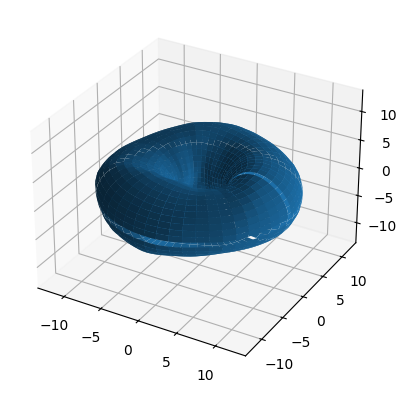

(99, 33)


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

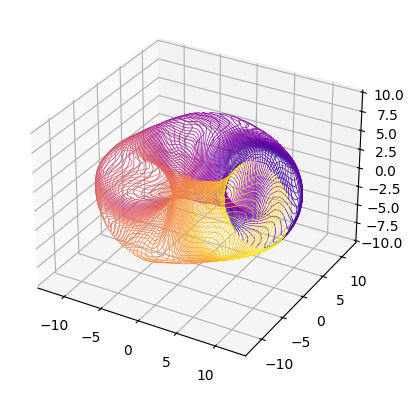

In [75]:
''' --- Calculating normalized field error of the solution --- '''
winding_surface = SurfaceRZFourier(
    nfp=nfp, 
    stellsym=stellsym, 
    mpol=mpol_winding, 
    ntor=ntor_winding, 
    quadpoints_phi=quadpoints_phi_winding, 
    quadpoints_theta=quadpoints_theta_winding, 
)
winding_surface.set_dofs(winding_dofs)
winding_surface.plot()
cp_temp = CurrentPotentialFourier(
    winding_surface=winding_surface, 
    mpol=mpol_cp, ntor=ntor_cp,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0,
    quadpoints_phi=winding_surface.quadpoints_phi,
    quadpoints_theta=winding_surface.quadpoints_theta,
    stellsym=winding_surface.stellsym
)
cp_temp.set_dofs(quadcoil_sln)
# Bfield = WindingSurfaceField(cp_temp)
# tgt_shape = (
#     len(plasma_surface.quadpoints_phi), 
#     len(plasma_surface.quadpoints_theta)
# )
# Jf_actual = SquaredFlux(
#     plasma_surface, 
#     Bfield, 
#     target=Bnormal_plasma_flat.reshape(tgt_shape),
#     definition='quadratic flux'
# )

# Jf_norm = SquaredFlux(
#     plasma_surface, 
#     Bfield, 
#     target=Bnormal_plasma_flat.reshape(tgt_shape),
#     definition='normalized'
# )
# Returns the predicted field error, the predicted normalized field error, 
# and the sheet current these errors are measured from
plot_coil_Phi_IG(cp_temp)

# Testing derivative

In [76]:
import jax.profiler

In [77]:
from jax import jacfwd, jacrev, jacobian
# fwd is better for more outputs than inputs
# rev is better for more inputs than outputs

In [78]:
type(coil_plasma_distance)

numpy.float32

In [79]:
simple_call_fit = lambda x:plasma_dofs_to_winding_dofs(
    # Dofs
    plasma_dofs=x.astype(jnp.float32),
    # Equilibrium and related parameters
    # Coil parameters
    coil_plasma_distance=coil_plasma_distance.astype(jnp.float32),
    # Numerical parameters
    nfp=nfp, 
    stellsym=stellsym, 
    mpol_plasma=mpol_plasma,
    ntor_plasma=ntor_plasma,
    quadpoints_phi_plasma=quadpoints_phi_plasma.astype(jnp.float32),
    quadpoints_theta_plasma=quadpoints_theta_plasma.astype(jnp.float32),
    mpol_winding=7, 
    ntor_winding=7,
)[0]

In [80]:
d_study_fit = jacobian(simple_call_fit)

In [81]:
d_study_fit(plasma_dofs)

theta_mesh_plasma, phi_mesh_plasma float32 float32
gamma_plasma float32
winding_dofs float32


Array([[ 9.77689564e-01,  3.67127061e-02, -1.34262413e-01, ...,
        -5.00114635e-02,  2.15377342e-02, -2.23474860e-01],
       [-8.91402364e-04,  4.01543200e-01,  5.17594159e-01, ...,
         2.76123025e-02,  2.51670748e-01,  2.61395603e-01],
       [-1.72924399e-02, -8.92563164e-03,  2.62784809e-02, ...,
        -1.26069158e-01,  3.69185247e-02,  9.47698131e-02],
       ...,
       [-1.36108976e-03,  3.49900220e-03,  5.32219745e-03, ...,
        -3.94035727e-01, -4.54895616e-01,  2.23407224e-01],
       [-8.66795075e-04,  1.54889713e-03, -2.15768442e-03, ...,
        -8.88340175e-02, -2.31705517e-01, -2.76735544e-01],
       [ 1.24610681e-03, -4.32556123e-03,  2.36267708e-02, ...,
        -3.36493328e-02,  1.24723904e-01, -2.22905919e-01]],      dtype=float32)

In [83]:

# Start profiling
jax.profiler.start_trace("/tmp/jax_profile")

2025-02-17 13:48:18.337237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739818098.400670 2303376 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739818098.418159 2303376 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [86]:
simple_call = lambda x: quadcoil_curvature_study(
    # Dofs
    plasma_dofs=x,

    # Equilibrium and related parameters
    Bnormal_plasma=Bnormal_plasma,
    net_poloidal_current_amperes=net_poloidal_current_amperes, # G
    net_toroidal_current_amperes=net_toroidal_current_amperes, # I

    # Coil parameters
    coil_plasma_distance=coil_plasma_distance,
    max_K2=max_K2,
    max_KK=max_KK,
    
    # Numerical parameters
    nfp=nfp, 
    stellsym=stellsym, 
    mpol_plasma=mpol_plasma,
    ntor_plasma=ntor_plasma,
    quadpoints_phi_plasma=quadpoints_phi_plasma,
    quadpoints_theta_plasma=quadpoints_theta_plasma,
    tol_outer=1e-4,
    tol_inner=1e-4,
    mpol_winding=7,
    ntor_winding=7,
    mpol_cp=4, 
    ntor_cp=4, 
    n_phi_eval_default=32,
    n_theta_eval_default=32,
)[0]
d_study = jacfwd(simple_call)
d_study_val = d_study(plasma_dofs)
jax.block_until_ready(d_study_val)

# Stop profiling
jax.profiler.stop_trace()

theta_mesh_plasma, phi_mesh_plasma float32 float32
1024


2025-02-17 13:49:11.648369: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 22.60GiB (24269140651 bytes) by rematerialization; only reduced to 39.11GiB (41998865580 bytes), down from 39.31GiB (42213964276 bytes) originally
2025-02-17 13:49:29.625272: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 26.21GiB (rounded to 28143179008)requested by op 
2025-02-17 13:49:29.625420: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___________________________________________________________________________________________________
E0217 13:49:29.625451 2303376 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 28143178832 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 28143178832 bytes.